### A few initial libraries ###

In [2]:
import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ
from qiskit.test.mock import FakeManhattan
from qiskit.test.mock import FakeBogota
from qiskit.test.mock import FakeMumbai
from qiskit.test.mock import FakeTokyo
from gate_variants.toffoli_variants import CCX_Variant_Gate 
from orientation_map import orientation_map_gen
from trios_bench.cnx_halfdirty import generate_cnx_halfdirty
from trios_bench.cnx_dirty import generate_dirty_multicontrol

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [46]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.18.3', 'qiskit-aer': '0.9.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.18.1', 'qiskit-aqua': '0.9.5', 'qiskit': '0.32.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

### Load device and the device configuration object ###

In [47]:
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q-ornl')
# device = FakeMumbai()

# backend_prop = device.properties()

ibmqfactory.load_account:WARNING:2022-04-06 15:42:32,201: Credentials are already in use. The existing account in the session will be replaced.


In [48]:
from qiskit_superstaq.superstaq_provider import SuperstaQProvider

In [49]:
superstaq_provider = SuperstaQProvider(api_key="ya29.A0ARrdaM-BWPjpkjhKgbVSRwWROaVE3g6mKCew2all4yXuPNLIwc6l65K10DiAMa-w8he0mR-i0Tb_jE6-GqqWlscj9Zq58rC2oSSzRVaLdZJMoy2bWqIXVhK3Tehp5N4zd8uHhyp01G9KC90Xmu3BKALiGiLP-w")

In [50]:
from level3_context import _parse_transpile_args, level_3_context_pass_manager
from level3_context_pulse import level_3_pass_manager, level_3_context_pulse_pass_manager, level_3_pulse_pass_manager

In [51]:
qc = generate_dirty_multicontrol(4,5)

In [52]:
qc.draw()

q_0: ────────────■───────────────────■───────
                 │                   │       
q_1: ────────────■───────────────────■───────
                 │                   │       
q_2: ───────■────┼────■─────────■────┼────■──
            │    │    │         │    │    │  
q_3: ──■────┼────┼────┼────■────┼────┼────┼──
     ┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │  
q_4: ┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼──
     └─┬─┘  │  ┌─┴─┐  │  └─┬─┘  │  ┌─┴─┐  │  
q_5: ──┼────■──┤ X ├──■────┼────■──┤ X ├──■──
       │  ┌─┴─┐└───┘┌─┴─┐  │  ┌─┴─┐└───┘┌─┴─┐
q_6: ──■──┤ X ├─────┤ X ├──■──┤ X ├─────┤ X ├
          └───┘     └───┘     └───┘     └───┘
q_7: ────────────────────────────────────────
                                             
q_8: ────────────────────────────────────────
                                             
q_9: ────────────────────────────────────────

In [54]:
backend = FakeMumbai()

In [55]:
#backend_prop = backend.properties()

In [56]:
orientation_map = None#orientation_map_gen(backend)

In [57]:
transpile_args = _parse_transpile_args([qc], backend, seed_transpiler = 0, orientation_map = orientation_map)

In [58]:
pass_manager_config = transpile_args[0]['pass_manager_config']

In [59]:
print(pass_manager_config.orientation_map)

None


In [60]:
pm_context = level_3_context_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [61]:
pm_orign = level_3_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [62]:
qc_context = pm_context.run(qc)

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
8: Qubit(QuantumRegister(10, 'q'), 0),
10: Qubit(QuantumRegister(10, 'q'), 1),
6: Qubit(QuantumRegister(10, 'q'), 2),
5: Qubit(QuantumRegister(10, 'q'), 3),
7: Qubit(QuantumRegister(10, 'q'), 4),
3: Qubit(QuantumRegister(10, 'q'), 5),
4: Qubit(QuantumRegister(10, 'q'), 6),
2: Qubit(QuantumRegister(10, 'q'), 7),
1: Qubit(QuantumRegister(10, 'q'), 8),
0: Qubit(QuantumRegister(10, 'q'), 9)
})
The physical qubits for the toffoli are:  4 1 7
The required toffoli will be decomposed using an 8 cnot decomposition - zero in center
('01', '12', 'l', 'p')
The physical qubits for the toffoli are:  1 7 4
The required toffoli will be decomposed using an 8 cnot decomposition - two in center
('01', '12', 'l', 'p')
The physical qubits for the toffoli are:  2 4 1
The required toffoli will be decomposed using an 8 cnot decomposition - two in center
('01', '12', 'l', 'p')
The physical qubits for the toffoli are:  4 10 7
The 

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/sympy/core/expr.py:3951: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  deprecated_since_version="1.9").warn()


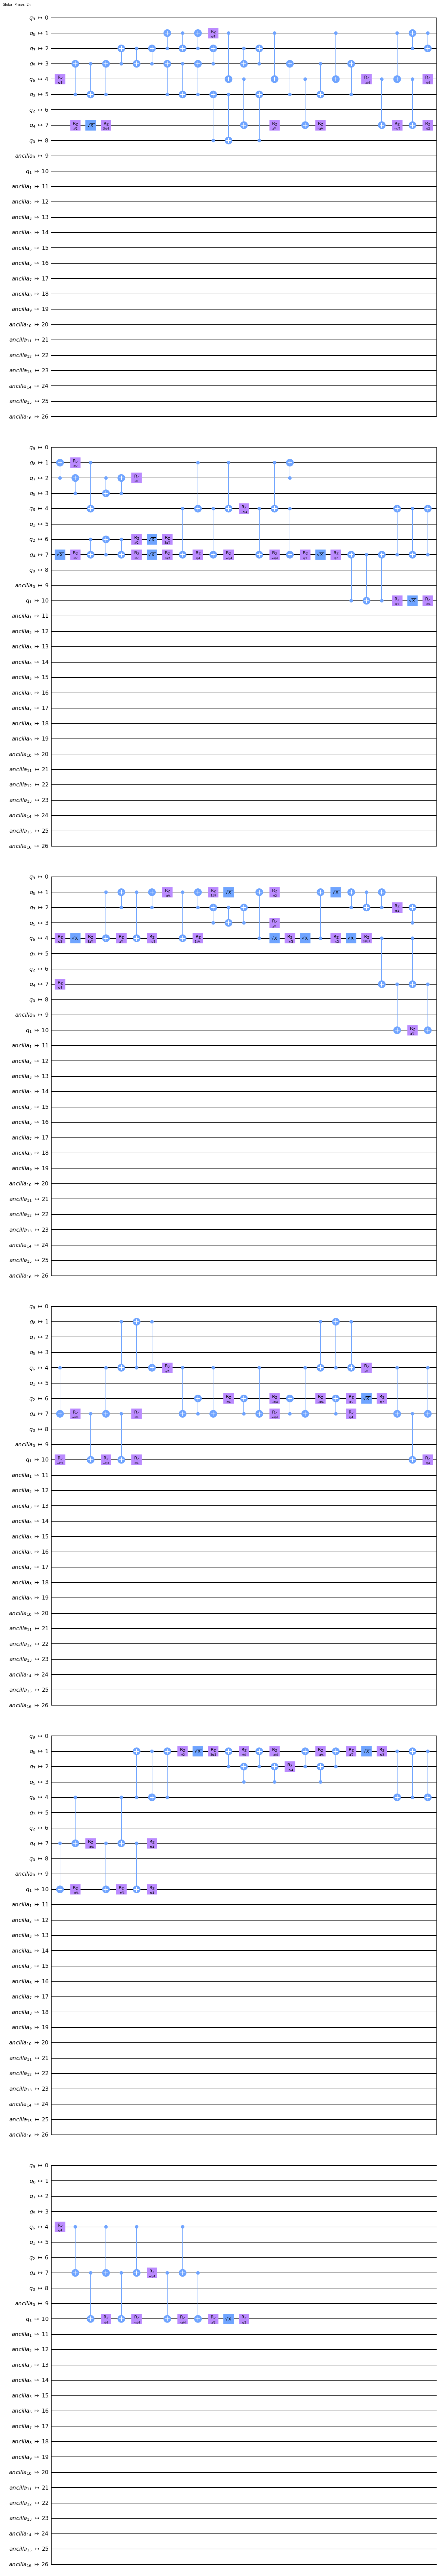

In [63]:
qc_context.draw(output = 'mpl')

In [64]:
qc_context.count_ops()

OrderedDict([('cx', 119), ('rz', 75), ('sx', 16)])

In [65]:
qc_orign = pm_orign.run(qc)

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
8: Qubit(QuantumRegister(10, 'q'), 0),
10: Qubit(QuantumRegister(10, 'q'), 1),
6: Qubit(QuantumRegister(10, 'q'), 2),
5: Qubit(QuantumRegister(10, 'q'), 3),
7: Qubit(QuantumRegister(10, 'q'), 4),
3: Qubit(QuantumRegister(10, 'q'), 5),
4: Qubit(QuantumRegister(10, 'q'), 6),
2: Qubit(QuantumRegister(10, 'q'), 7),
1: Qubit(QuantumRegister(10, 'q'), 8),
0: Qubit(QuantumRegister(10, 'q'), 9)
})


In [66]:
qc_orign.count_ops()

OrderedDict([('cx', 119), ('rz', 80), ('sx', 19)])

In [7]:
                circuit = QuantumCircuit(3)
                circuit.h(2)
                circuit.t([0, 1, 2])
                circuit.cx(0, 1)
                circuit.cx(1, 2)
                circuit.cx(0, 1)
                circuit.t(2)
                circuit.cx(1, 2)
                circuit.cx(0, 1)
                circuit.tdg([1, 2])
                circuit.cx(1, 2)
                circuit.cx(0, 1)
                circuit.tdg(2)
                circuit.cx(1, 2)
                circuit.h(2)

In [8]:
circuit.draw()

┌───┐                                                        
q_0: ┤ T ├──■─────────■──────────■──────────────────■─────────────
     ├───┤┌─┴─┐     ┌─┴─┐      ┌─┴─┐ ┌─────┐      ┌─┴─┐           
q_1: ┤ T ├┤ X ├──■──┤ X ├──■───┤ X ├─┤ Tdg ├──■───┤ X ├───■───────
     ├───┤├───┤┌─┴─┐├───┤┌─┴─┐┌┴───┴┐└─────┘┌─┴─┐┌┴───┴┐┌─┴─┐┌───┐
q_2: ┤ H ├┤ T ├┤ X ├┤ T ├┤ X ├┤ Tdg ├───────┤ X ├┤ Tdg ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└─────┘       └───┘└─────┘└───┘└───┘

In [3]:
            circuit = QuantumCircuit(3)
            circuit.h(1)
            circuit.t([0, 1, 2])
            circuit.cx(0, 1)
            circuit.cx(1, 2)
            circuit.cx(0, 1)
            circuit.t(2)
            circuit.cx(1, 2)
            circuit.cx(0, 1)
            circuit.tdg([1, 2])
            circuit.cx(1, 2)
            circuit.cx(0, 1)
            circuit.tdg(2)
            circuit.cx(1, 2)
            circuit.h(1)

In [4]:
circuit.draw()

┌───┐                                                             
q_0: ┤ T ├───────■─────────■──────────■──────────────────■─────────────
     ├───┤┌───┐┌─┴─┐     ┌─┴─┐      ┌─┴─┐ ┌─────┐      ┌─┴─┐      ┌───┐
q_1: ┤ H ├┤ T ├┤ X ├──■──┤ X ├──■───┤ X ├─┤ Tdg ├──■───┤ X ├───■──┤ H ├
     ├───┤└───┘└───┘┌─┴─┐├───┤┌─┴─┐┌┴───┴┐└─────┘┌─┴─┐┌┴───┴┐┌─┴─┐└───┘
q_2: ┤ T ├──────────┤ X ├┤ T ├┤ X ├┤ Tdg ├───────┤ X ├┤ Tdg ├┤ X ├─────
     └───┘          └───┘└───┘└───┘└─────┘       └───┘└─────┘└───┘

In [11]:
            circuit = QuantumCircuit(3)
            circuit.h(2)
            circuit.t([0, 2, 1])
            circuit.cx(0, 2)
            circuit.cx(2, 1)
            circuit.cx(0, 2)
            circuit.t(1)
            circuit.cx(2, 1)
            circuit.cx(0, 2)
            circuit.tdg([2, 1])
            circuit.cx(2, 1)
            circuit.cx(0, 2)
            circuit.tdg(1)
            circuit.cx(2, 1)
            circuit.h(2)

In [12]:
circuit.draw()

┌───┐                                                                     
q_0: ┤ T ├───────■─────────■──────────────■────────────────■───────────────────
     ├───┤       │  ┌───┐  │  ┌───┐┌───┐  │  ┌─────┐┌───┐  │  ┌─────┐┌───┐     
q_1: ┤ T ├───────┼──┤ X ├──┼──┤ T ├┤ X ├──┼──┤ Tdg ├┤ X ├──┼──┤ Tdg ├┤ X ├─────
     ├───┤┌───┐┌─┴─┐└─┬─┘┌─┴─┐└───┘└─┬─┘┌─┴─┐├─────┤└─┬─┘┌─┴─┐└─────┘└─┬─┘┌───┐
q_2: ┤ H ├┤ T ├┤ X ├──■──┤ X ├───────■──┤ X ├┤ Tdg ├──■──┤ X ├─────────■──┤ H ├
     └───┘└───┘└───┘     └───┘          └───┘└─────┘     └───┘            └───┘

In [9]:
                circuit = QuantumCircuit(3)
                circuit.h(2)
                circuit.t([1, 0, 2])
                circuit.cx(1, 0)
                circuit.cx(0, 2)
                circuit.cx(1, 0)
                circuit.t(2)
                circuit.cx(0, 2)
                circuit.cx(1, 0)
                circuit.tdg([0, 2])
                circuit.cx(0, 2)
                circuit.cx(1, 0)
                circuit.tdg(2)
                circuit.cx(0, 2)
                circuit.h(2)

In [10]:
circuit.draw()

┌───┐┌───┐     ┌───┐      ┌───┐ ┌─────┐      ┌───┐           
q_0: ┤ T ├┤ X ├──■──┤ X ├──■───┤ X ├─┤ Tdg ├──■───┤ X ├───■───────
     ├───┤└─┬─┘  │  └─┬─┘  │   └─┬─┘ └─────┘  │   └─┬─┘   │       
q_1: ┤ T ├──■────┼────■────┼─────■────────────┼─────■─────┼───────
     ├───┤┌───┐┌─┴─┐┌───┐┌─┴─┐┌─────┐       ┌─┴─┐┌─────┐┌─┴─┐┌───┐
q_2: ┤ H ├┤ T ├┤ X ├┤ T ├┤ X ├┤ Tdg ├───────┤ X ├┤ Tdg ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└─────┘       └───┘└─────┘└───┘└───┘